**Import des données**

In [57]:
# 📦 Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('../data/parquet/full_2020.csv.parquet', engine='pyarrow')

**Optimisation**

In [58]:
# Liste des colonnes à supprimer (remplissage < 10%)
cols_to_drop_1 = [
    'ancien_code_commune', 'ancien_nom_commune', 'ancien_id_parcelle',
    'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez',
    'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez',
    'lot5_numero', 'lot5_surface_carrez'
]
# Liste des colonnes avec infos inutiles
cols_to_drop_2 = [
    'id_mutation', 'numero_disposition', 'adresse_numero', 'adresse_suffixe',
    'adresse_nom_voie', 'adresse_code_voie', 'nom_commune', 'id_parcelle',
    'numero_volume', 'code_nature_culture', 'nature_culture','code_nature_culture_speciale'
]
df.drop(columns=cols_to_drop_1, inplace=True)
# Vérification des colonnes restantes
print(f"Shape after dropping columns: {df.shape}")

def optimize_dataframe(df, parse_dates=None, category_thresh=0.05, verbose=True):
    """
    Optimise les types d'un DataFrame pour réduire l'utilisation mémoire :
    - convertit les objets en catégories si nombre de modalités faible
    - convertit les float64 en float32
    - convertit les int64 en int32
    - convertit les colonnes de dates

    Parameters:
    - df : DataFrame à optimiser
    - parse_dates : liste de colonnes à parser comme dates
    - category_thresh : seuil max de ratio modalité/nb lignes pour transformer en 'category'
    - verbose : affiche la mémoire gagnée

    Returns:
    - df optimisé
    """

    initial_memory = df.memory_usage(deep=True).sum() / 1024**2

    # Dates
    if parse_dates:
        for col in parse_dates:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Float → float32
    float_cols = df.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df[col] = df[col].astype('float32')

    # Int → int32
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        if df[col].isnull().any():
            df[col] = df[col].astype('Int32')
        else:
            df[col] = df[col].astype('int32')

    # Object → category si peu de modalités
    for col in df.select_dtypes(include='object').columns:
        if df[col].nunique(dropna=False) / len(df) <= category_thresh:
            df[col] = df[col].astype('category')

    final_memory = df.memory_usage(deep=True).sum() / 1024**2

    if verbose:
        print(f"💾 Mémoire utilisée : {initial_memory:.2f} Mo → {final_memory:.2f} Mo ({100 * (1 - final_memory/initial_memory):.1f}% gagné)")

    return df

# Application test sur ech_annonces_ventes_68.csv
optimized_df1 = optimize_dataframe(df, parse_dates=['date_mutation'], verbose=True)
optimized_df1.info()



Shape after dropping columns: (3522416, 27)
💾 Mémoire utilisée : 2855.43 Mo → 862.50 Mo (69.8% gagné)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522416 entries, 0 to 3522415
Data columns (total 27 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   id_mutation                   object        
 1   date_mutation                 datetime64[ns]
 2   numero_disposition            int32         
 3   nature_mutation               category      
 4   valeur_fonciere               float32       
 5   adresse_numero                float32       
 6   adresse_suffixe               category      
 7   adresse_nom_voie              object        
 8   adresse_code_voie             category      
 9   code_postal                   float32       
 10  code_commune                  category      
 11  nom_commune                   category      
 12  code_departement              category      
 13  id_parcelle                   

**Pré processing**

In [59]:
# optimized_df1 = optimized_df1.dropna()
optimized_df1.head()

# Le but est de voir si la commune est grande ou petite en fonction du nombre d'apparition dans le tableau
commune_freq = optimized_df1['nom_commune'].value_counts()
optimized_df1['commune_freq'] = optimized_df1['nom_commune'].map(commune_freq)

optimized_df1 = optimized_df1.drop(['adresse_numero', 'adresse_suffixe', 'adresse_nom_voie','adresse_code_voie', 'code_postal', 'nom_commune','numero_volume','nature_culture_speciale','code_nature_culture_speciale'], axis=1)

optimized_df1['coordonnees'] = list(zip(optimized_df1['latitude'], optimized_df1['longitude']))


optimized_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522416 entries, 0 to 3522415
Data columns (total 20 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   id_mutation                object        
 1   date_mutation              datetime64[ns]
 2   numero_disposition         int32         
 3   nature_mutation            category      
 4   valeur_fonciere            float32       
 5   code_commune               category      
 6   code_departement           category      
 7   id_parcelle                object        
 8   nombre_lots                int32         
 9   code_type_local            float32       
 10  type_local                 category      
 11  surface_reelle_bati        float32       
 12  nombre_pieces_principales  float32       
 13  code_nature_culture        category      
 14  nature_culture             category      
 15  surface_terrain            float32       
 16  longitude                  float32  

**Encoding**

In [60]:

optimized_df1['code_type_local'] = optimized_df1['code_type_local'].fillna(0)
optimized_df1['code_type_local'] = optimized_df1['code_type_local'].astype(int)
# Valeur possible Naan,1,2,3,4  -> valeur encodé 0,1,2,3,4


optimized_df1['type_local'] = optimized_df1['type_local'].astype('string')
optimized_df1['type_local'] = optimized_df1['type_local'].fillna('Inconnu')
categories = ['Inconnu', 'Maison', 'Appartement', 'Dépendance', 'Local industriel. commercial ou assimilé']
optimized_df1['type_local'] = pd.Categorical(optimized_df1['type_local'], categories=categories)
optimized_df1['type_local'] = optimized_df1['type_local'].cat.codes
# Inconnu -> 0, 'Maison' -> 1, 'Appartement' -> 2, 'Dépendance' -> 3, 'Local industriel. commercial ou assimilé' -> 4


optimized_df1['nature_mutation'] = optimized_df1['nature_mutation'].astype('string')
categories = ['Vente', 'Vente terrain à bâtir', 'Echange', "Vente en l'état futur d'achèvement", 'Adjudication','Expropriation']
optimized_df1['nature_mutation'] = pd.Categorical(optimized_df1['nature_mutation'], categories=categories)
optimized_df1['nature_mutation'] = optimized_df1['nature_mutation'].cat.codes
# Vente -> 0, 'Vente terrain à bâtir' -> 1, 'Echange' -> 2, 'Vente en l'état futur d'achèvement' -> 3, 'Adjudication' -> 4, 'Expropriation' -> 5


optimized_df1['code_nature_culture'] = optimized_df1['code_nature_culture'].astype('string')
optimized_df1['code_nature_culture'] = optimized_df1['code_nature_culture'].fillna(0)
categories = [ 0,'T', 'BT', 'AB', 'S', 'J', 'P', 'BS', 'AG', 'L', 'VI', 'VE', 'BP', 'CH', 'BR', 'E', 'BF', 'CA', 'B', 'PA', 'BM', 'BO', 'PP', 'PC', 'TP', 'LB', 'PH', 'PE']
optimized_df1['code_nature_culture'] = pd.Categorical(optimized_df1['code_nature_culture'], categories=categories)
optimized_df1['code_nature_culture'] = optimized_df1['code_nature_culture'].cat.codes
# 0 -> 0, 1 -> 'T', 2 -> 'BT', 3 -> 'AB', 4 -> 'S', 5 -> 'J', 6 -> 'P', 7 -> 'BS', 8 -> 'AG', 9 -> 'L', 10 -> 'VI', 11 -> 'VE', 12 -> 'BP', 13 -> 'CH', 14 -> 'BR', 15 -> 'E', 16 -> 'BF', 17 -> 'CA', 18 -> 'B', 19 -> 'PA', 20 -> 'BM', 21 -> 'BO', 22 -> 'PP', 23 -> 'PC', 24 -> 'TP', 25 -> 'LB', 26 -> 'PH', 27 -> 'PE'

optimized_df1['nature_culture'] = optimized_df1['nature_culture'].astype('string')
optimized_df1['nature_culture'] = optimized_df1['nature_culture'].fillna(0)
categories = [ 0,'terres', 'taillis simples', 'terrains a bâtir', 'sols', 'jardins', 'prés', 'taillis sous futaie', "terrains d'agrément", 'landes', 'vignes', 'vergers', 'peupleraies', 'chemin de fer', 'futaies résineuses', 'eaux', 'futaies feuillues', 'carrières', 'bois', 'pâtures', 'futaies mixtes', 'oseraies', 'prés plantes', 'pacages', 'terres plantées', 'landes boisées', 'herbages', "prés d'embouche"]
optimized_df1['nature_culture'] = pd.Categorical(optimized_df1['nature_culture'], categories=categories)
optimized_df1['nature_culture'] = optimized_df1['nature_culture'].cat.codes
# 0 -> 0, 1 -> 'terres', 2 -> 'taillis simples', 3 -> 'terrains a bâtir', 4 -> 'sols', 5 -> 'jardins', 6 -> 'prés', 7 -> 'taillis sous futaie', 8 -> "terrains d'agrément", 9 -> 'landes', 10 -> 'vignes', 11 -> 'vergers', 12 -> 'peupleraies', 13 -> 'chemin de fer', 14 -> 'futaies résineuses', 15 -> 'eaux', 16 -> 'futaies feuillues', 17 -> 'carrières', 18 -> 'bois', 19 -> 'pâtures', 20 -> 'futaies mixtes', 21 -> 'oseraies', 22 -> 'prés plantes', 23 -> 'pacages', 24 -> 'terres plantées', 25 -> 'landes boisées', 26 -> 'herbages', 27 -> "prés d'embouche"


**Post DropNa**

In [61]:
optimized_df1 = optimized_df1.dropna()


# Corrélation de Spearman
spearman_corr = optimized_df1.corr(method='spearman', numeric_only=True)

# Extraire les corrélations avec 'valeur_fonciere' uniquement
valeur_corr_spearman = spearman_corr['valeur_fonciere'].drop('valeur_fonciere')

# Trier par valeur absolue (décroissant)
valeur_corr_spearman_sorted = valeur_corr_spearman.reindex(valeur_corr_spearman.abs().sort_values(ascending=False).index)

# Affichage
print(valeur_corr_spearman_sorted)


commune_freq                 0.352145
surface_terrain              0.261448
surface_reelle_bati          0.221233
code_type_local              0.209986
type_local                   0.209986
nombre_pieces_principales    0.124774
longitude                    0.096420
latitude                    -0.082885
nature_culture               0.051102
code_nature_culture          0.051102
numero_disposition          -0.015459
nature_mutation             -0.014929
nombre_lots                  0.013429
Name: valeur_fonciere, dtype: float64


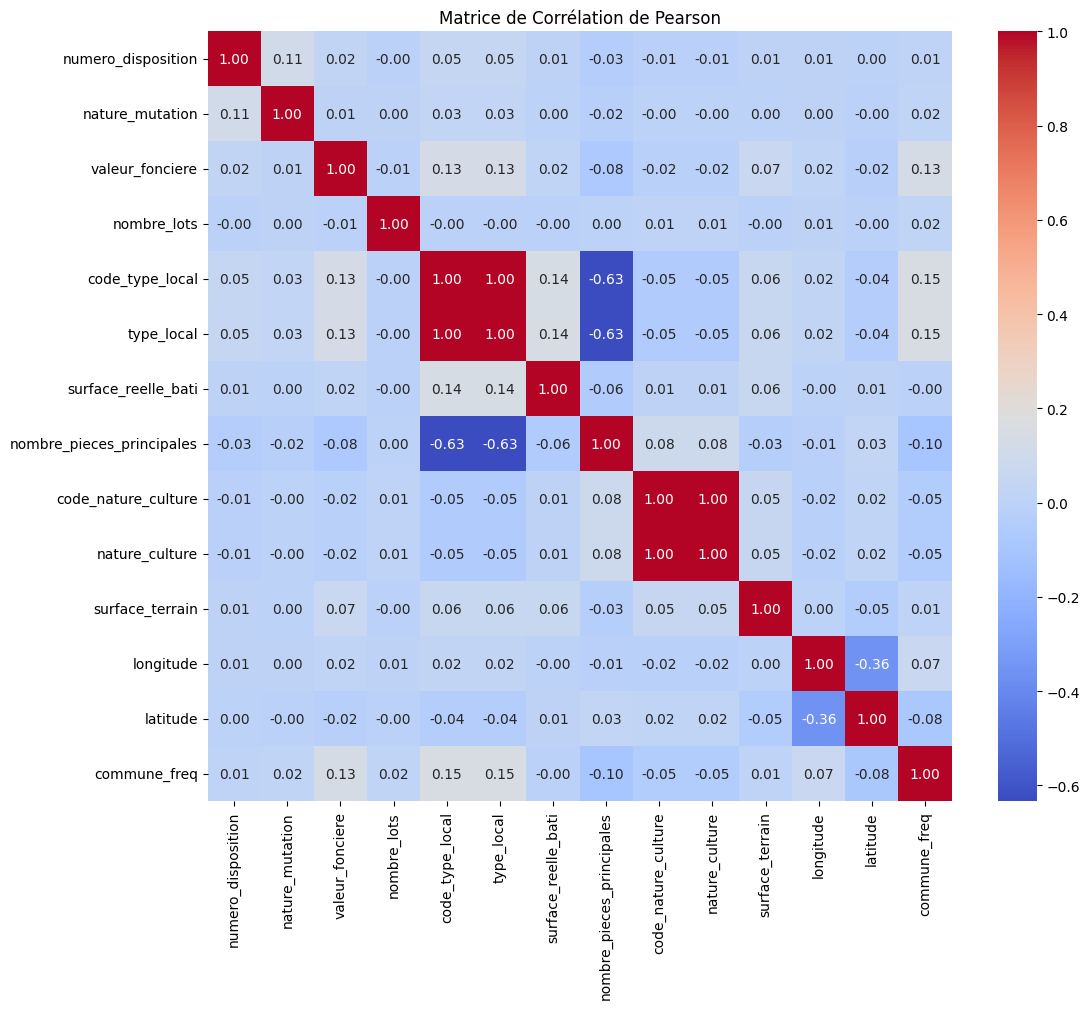

In [68]:
colonnes_choisies = ['valeur_fonciere', 'surface_terrain', 'surface_reelle_bati', 'type_local', 'code_type_local', 'nombre_pieces_principales', 'coordonnees', 'commune_freq', 'nombre_lots']
dfFirstTenta = optimized_df1[colonnes_choisies].copy()
dfFirstTenta

# Corrélation de Pearson avec 'valeur_fonciere'
valeur_corr = correlation_matrix['valeur_fonciere'].drop('valeur_fonciere')

# Trier par ordre décroissant de valeur absolue
valeur_corr_sorted = valeur_corr.reindex(valeur_corr.abs().sort_values(ascending=False).index)


# Visualiser avec une heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Matrice de Corrélation de Pearson")
plt.show()